# Bibliotecas

In [134]:
import yfinance as yf
from matplotlib import pyplot as plt
import pandas as pd
import mplfinance as mplf
from os.path import exists
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor

# Obter Dados

In [135]:
if not exists('historico.csv'):
    hist = yf.download('ITSA4.SA', period='3y', interval='1d')
    hist.to_csv('historico.csv')
else:
    hist = pd.read_csv('historico.csv', index_col='Date', parse_dates=True)  
hist

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-29,8.43,8.57,8.36,8.56,7.30,51527668
2020-06-30,8.48,8.53,8.29,8.30,7.08,44962302
2020-07-01,8.37,8.55,8.35,8.48,7.23,29598838
2020-07-02,8.61,8.82,8.58,8.61,7.35,34672984
2020-07-03,8.61,8.69,8.52,8.63,7.36,12221863
...,...,...,...,...,...,...
2023-06-21,9.80,9.95,9.79,9.89,9.77,19003800
2023-06-22,9.80,9.86,9.71,9.77,9.66,16028300
2023-06-23,9.70,9.72,9.57,9.66,9.66,12688500


# Tratamento de Dados

### Ajuste de Preços

In [136]:
histAdj = hist.copy()
histAdj = histAdj.drop(columns=['Adj Close', 'Volume'])
adj = hist['Adj Close'] / hist['Close']
histAdj = histAdj.multiply(adj, axis=0)
histAdj

,Open,High,Low,Close
Date,,,,
2020-06-29,7.19,7.31,7.13,7.30
2020-06-30,7.24,7.28,7.08,7.08
2020-07-01,7.14,7.29,7.12,7.23
2020-07-02,7.34,7.53,7.32,7.35
2020-07-03,7.35,7.42,7.27,7.36
...,...,...,...,...
2023-06-21,9.69,9.83,9.68,9.77
2023-06-22,9.69,9.74,9.60,9.66
2023-06-23,9.70,9.72,9.57,9.66


### Gerando colunas com preços passados

In [137]:
for i in range(10):
    histAdj['Close'+str(i+1)] = histAdj['Close'].shift(i+1)
    histAdj['Open'+str(i+1)] = histAdj['Open'].shift(i+1)
    histAdj['High'+str(i+1)] = histAdj['High'].shift(i+1)
    histAdj['Low'+str(i+1)] = histAdj['Low'].shift(i+1)
histAdj = histAdj.dropna()
histAdj

,Open,High,Low,Close,Close1,Open1,High1,Low1,Close2,Open2,...,High8,Low8,Close9,Open9,High9,Low9,Close10,Open10,High10,Low10
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-13,7.57,7.62,7.42,7.42,7.56,7.50,7.58,7.44,7.53,7.53,...,7.29,7.12,7.08,7.24,7.28,7.08,7.30,7.19,7.31,7.13
2020-07-14,7.42,7.52,7.35,7.50,7.42,7.57,7.62,7.42,7.56,7.50,...,7.53,7.32,7.23,7.14,7.29,7.12,7.08,7.24,7.28,7.08
2020-07-15,7.57,7.64,7.52,7.59,7.50,7.42,7.52,7.35,7.42,7.57,...,7.42,7.27,7.35,7.34,7.53,7.32,7.23,7.14,7.29,7.12
2020-07-16,7.53,7.57,7.48,7.50,7.59,7.57,7.64,7.52,7.50,7.42,...,7.67,7.47,7.36,7.35,7.42,7.27,7.35,7.34,7.53,7.32
2020-07-17,7.53,7.63,7.50,7.59,7.50,7.53,7.57,7.48,7.59,7.57,...,7.61,7.36,7.65,7.52,7.67,7.47,7.36,7.35,7.42,7.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-21,9.69,9.83,9.68,9.77,9.70,9.65,9.71,9.58,9.66,9.58,...,9.14,8.98,9.00,9.06,9.06,8.91,8.98,9.00,9.11,8.96
2023-06-22,9.69,9.74,9.60,9.66,9.77,9.69,9.83,9.68,9.70,9.65,...,9.20,9.08,9.12,9.03,9.14,8.98,9.00,9.06,9.06,8.91
2023-06-23,9.70,9.72,9.57,9.66,9.66,9.69,9.74,9.60,9.77,9.69,...,9.28,9.11,9.16,9.11,9.20,9.08,9.12,9.03,9.14,8.98


# Teste de Modelo de Regressão

### Separar dados de treino e teste

In [138]:
x = histAdj.drop(columns=['Open', 'Close', 'High', 'Low']).values
y = histAdj[['Open', 'Close', 'High', 'Low']].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

### Lazy Regressor

In [139]:
from lazypredict.Supervised import LazyRegressor

lazyReg = LazyRegressor(ignore_warnings=False)
lazyReg.fit(x_train, x_test, y_train, y_test)

  5%|▍         | 2/42 [00:00<00:04,  9.44it/s]

AdaBoostRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.


 19%|█▉        | 8/42 [00:00<00:01, 28.95it/s]

BayesianRidge model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
ElasticNetCV model failed to execute
For multi-task outputs, use MultiTaskElasticNetCV


 40%|████      | 17/42 [00:01<00:01, 16.84it/s]

GammaRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
GradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
HistGradientBoostingRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
HuberRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
LarsCV model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.


 57%|█████▋    | 24/42 [00:01<00:00, 25.94it/s]

LassoCV model failed to execute
For multi-task outputs, use MultiTaskLassoCV
LassoLarsCV model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
LassoLarsIC model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
LinearSVR model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.


 69%|██████▉   | 29/42 [00:01<00:00, 14.98it/s]

NuSVR model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
OrthogonalMatchingPursuitCV model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
PassiveAggressiveRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
PoissonRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
QuantileRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.


 86%|████████▌ | 36/42 [00:03<00:01,  5.34it/s]

SGDRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
SVR model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.
TweedieRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.


100%|██████████| 42/42 [00:04<00:00,  9.64it/s]

LGBMRegressor model failed to execute
y should be a 1d array, got an array of shape (551, 4) instead.


(                            Adjusted R-Squared  R-Squared  RMSE  Time Taken
 Model                                                                      
 OrthogonalMatchingPursuit                 0.97       0.98  0.09        0.02
 RidgeCV                                   0.97       0.98  0.09        0.02
 Ridge                                     0.97       0.98  0.09        0.02
 TransformedTargetRegressor                0.97       0.98  0.09        0.02
 LinearRegression                          0.97       0.98  0.09        0.02
 RandomForestRegressor                     0.97       0.98  0.09        1.78
 ExtraTreesRegressor                       0.97       0.98  0.09        0.55
 Lars                                      0.97       0.97  0.10        0.04
 BaggingRegressor                          0.96       0.97  0.10        0.19
 XGBRegressor                              0.96       0.97  0.11        0.42
 DecisionTreeRegressor                     0.94       0.95  0.13        0.03

### Criando um dos modelos encontrados

In [140]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from math import sqrt

modelo = OrthogonalMatchingPursuit()
modelo.fit(x_train, y_train)
print('Treino R2:', r2_score(y_train, modelo.predict(x_train)))
print('Teste R2:', r2_score(y_test, modelo.predict(x_test)))
print('Treino RMSE:', sqrt(mean_squared_error(y_train, modelo.predict(x_train))))
print('Teste RMSE:', sqrt(mean_squared_error(y_test, modelo.predict(x_test))))

Treino R2: 0.9726039408674538
Teste R2: 0.978824102653414
Treino RMSE: 0.10076087082245964
Teste RMSE: 0.08804793175440136


# Visualização

### Dados do Histórico

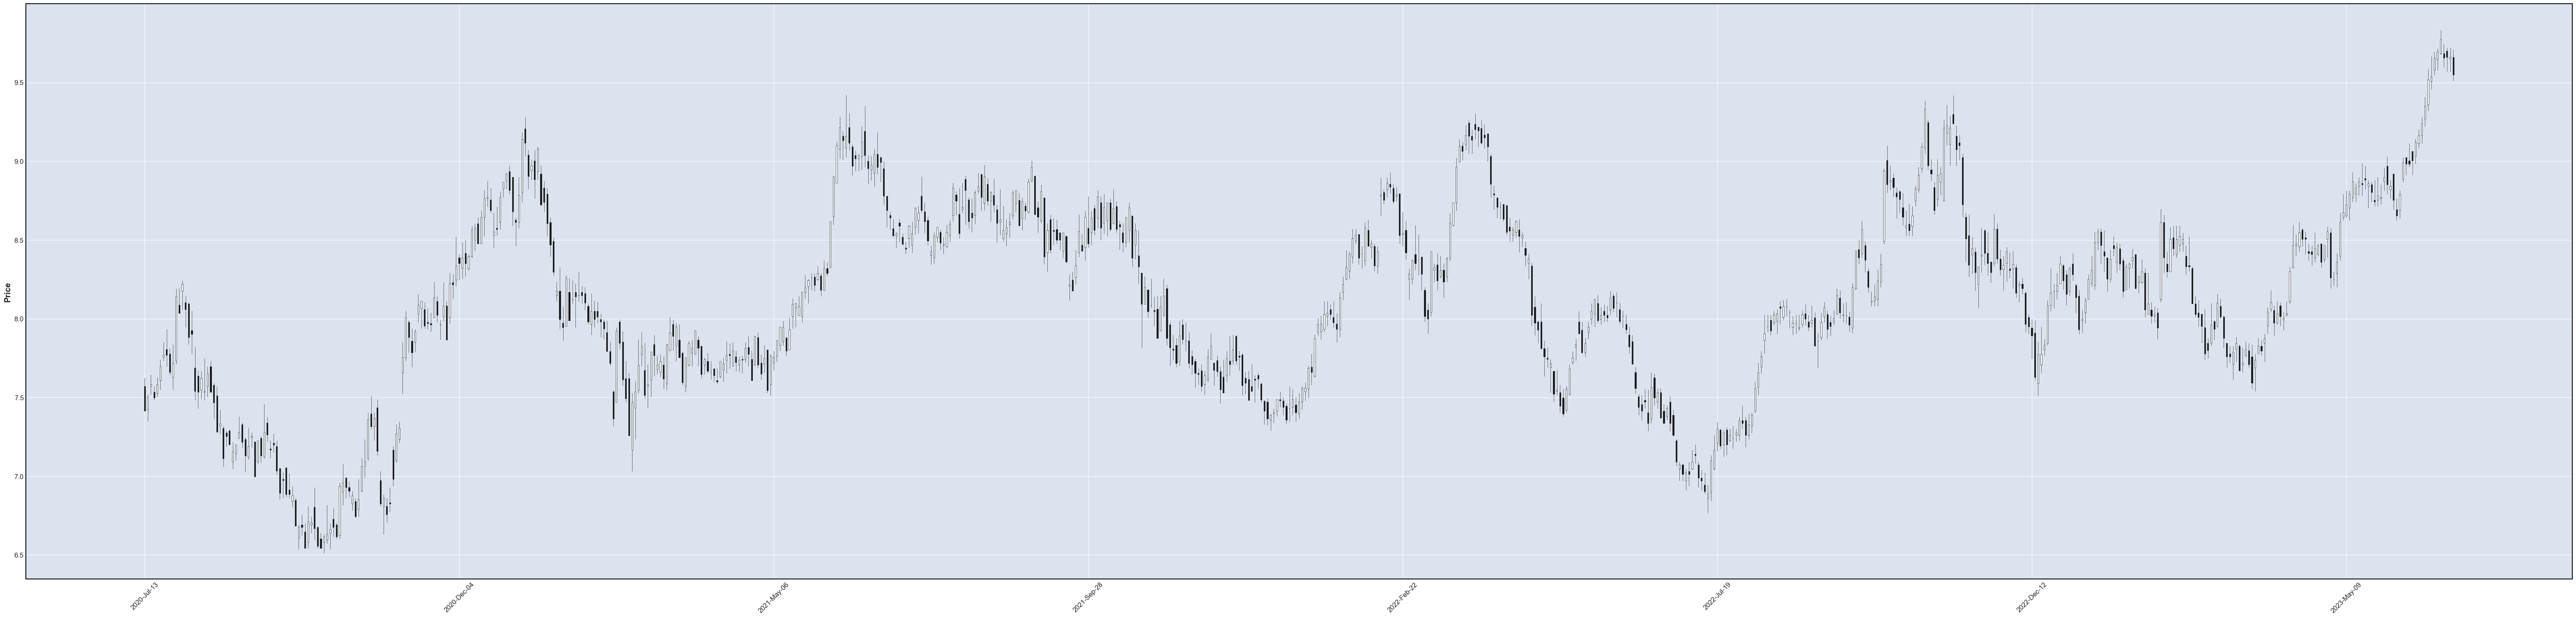

In [161]:
fig = mplf.figure(figsize=(80, 40))
mplf.plot(histAdj, type='candle', ax=fig.add_subplot(2, 1, 1))